In [11]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import os

from dataset import LinemodDataset
from model.network import get_prediction_from_model_output

In [12]:
dataset_path = 'data/Linemod_preprocessed'
path_to_trained_model = 'posenet.pt'
path_to_plot_dir = 'plots/'

In [13]:
dataset = LinemodDataset(mode="eval", dataset_path=dataset_path, cloud_pt_num=500)
object_list = dataset.objects
indices = [500, 1500, 2500, 3500, 4500, 5500, 6500, 7500, 8500, 9500, 10500, 11500, 12500]
model = torch.load(path_to_trained_model, map_location=torch.device('cpu'))
model.eval()

PoseNet(
  (pspnet): PSPNet(
    (feats): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(6

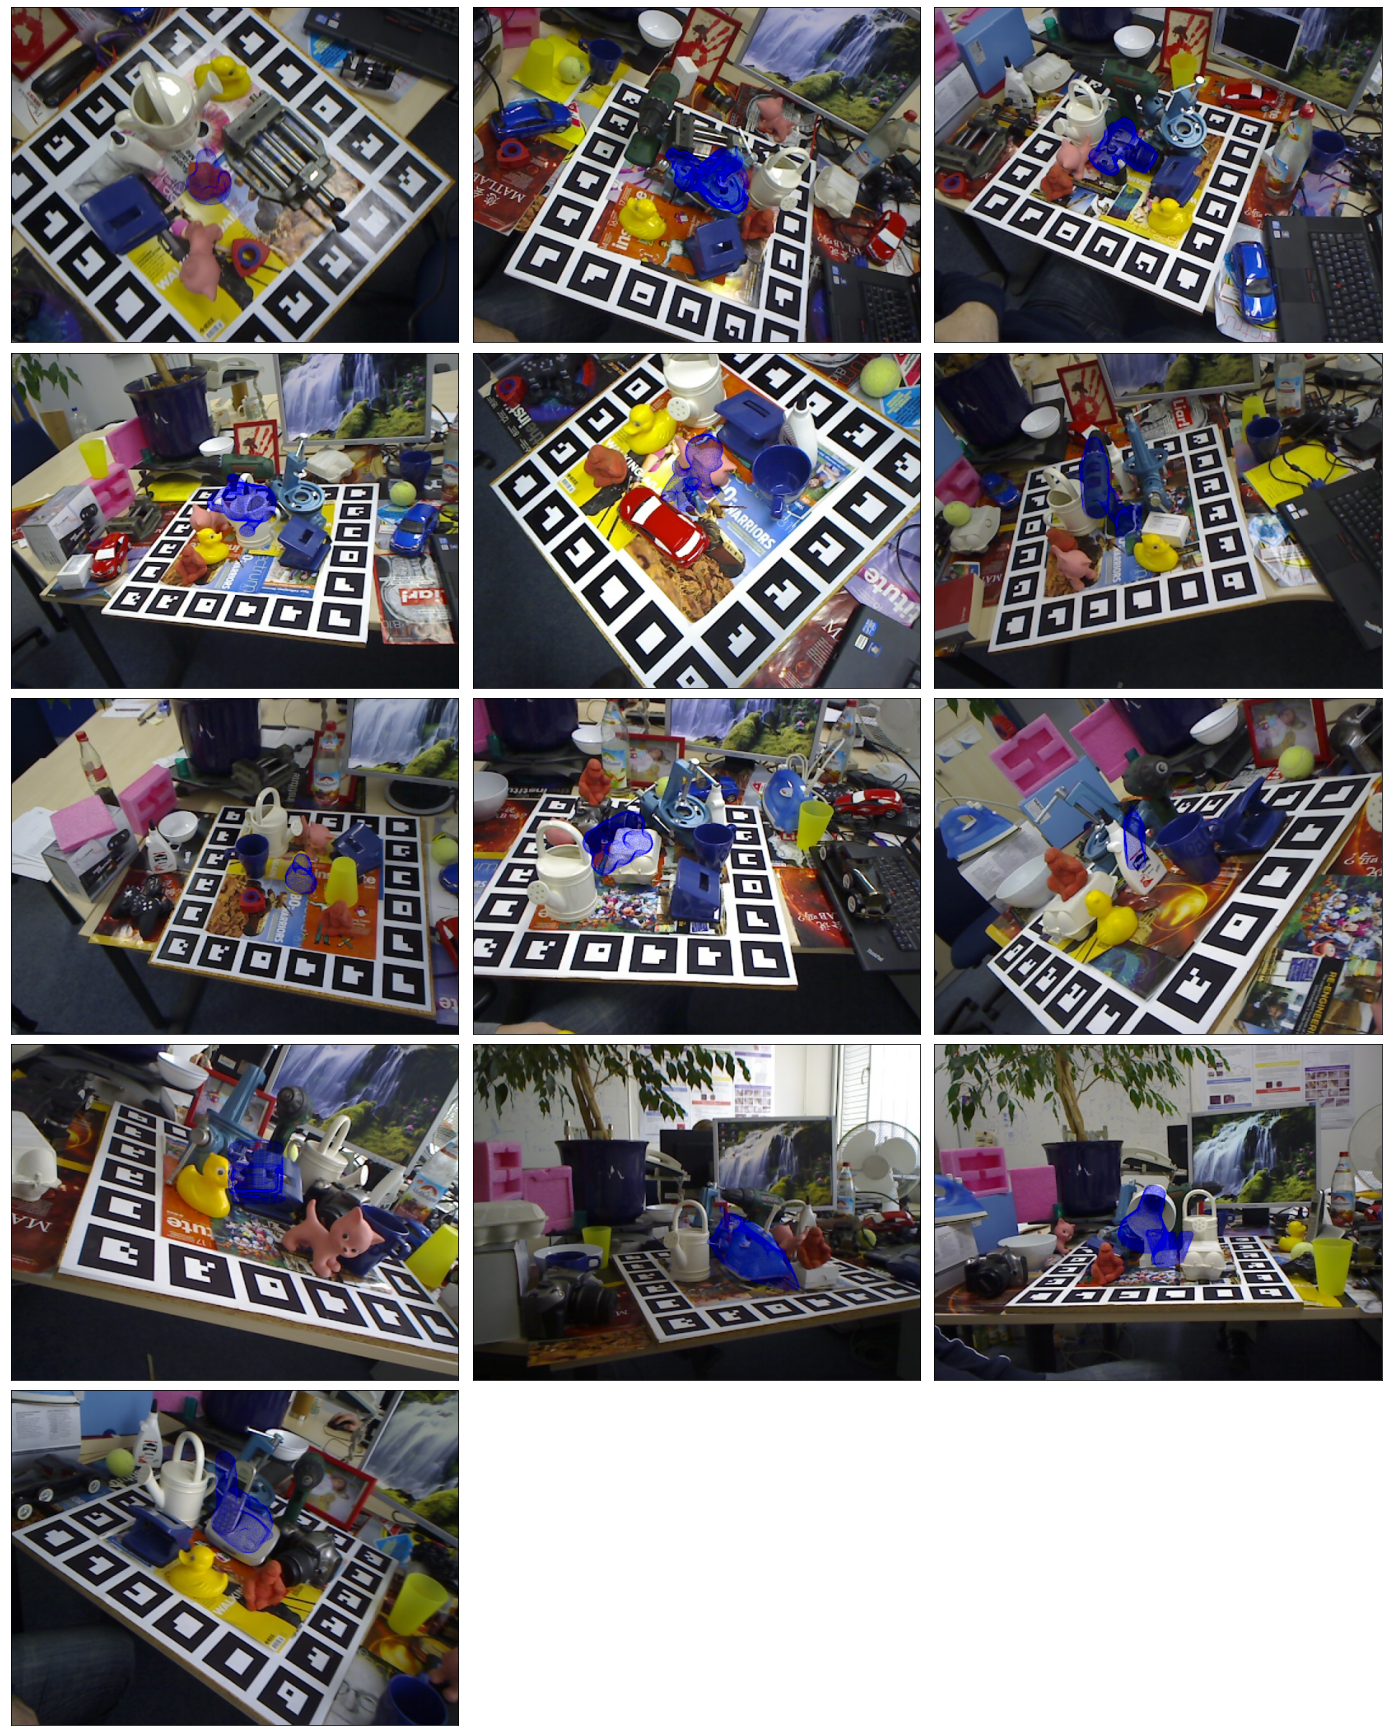

In [14]:
fig, axes = plt.subplots(ncols=3, nrows=int(np.ceil(len(indices) / 3)), sharex=True, sharey=True, figsize=(19.2, 24), constrained_layout=True)

for i, index in enumerate(indices):
    # cloud: object point cloud, shape: 500 x 3
    # choice: mask to obtain the object point cloud, shape: 1 x 500
    # img_crop: rgb image cropped to the bounding box of the object, shape: 3 x bounding_box_length x bounding_box_length
    # target_t: unit vectors pointing from each object point to the ground truth center, shape: 500 x 3
    # target_r: model points with ground truth rotation from model to camera coordinates applied, shape: 500 x 3
    # model_vtx: model vertices (downsampled to 500), shape: 500 x 3
    # obj_idx: index of the object in the list of object ids, shape: 1
    # gt_t: ground truth vector to object center, shape: 3
    cloud, choice, img_crop, target_t, target_r, model_vtx, obj_idx, gt_t = dataset[index]

    # pred_r: predicted rotations as quaternions, one per rotation anchor, shape: 1 x num_rot_anchors x 4
    # pred_t: predicted unit vectors pointing from each object point to its center, shape: 1 x 500 x 3
    # pred_c: predicted unit vectors pointing from each object point to its center, shape: 1 x num_rot_anchors
    pred_r, pred_t, pred_c = model(img_crop.unsqueeze(0), cloud.unsqueeze(0), choice.unsqueeze(0), obj_idx.unsqueeze(0))
    # pred_r: final estimate of the rotation matrix, shape: 3 x 3
    # pred_t: final estimate of the translation vector, shape: 1 x 3
    pred_r, pred_t = get_prediction_from_model_output(pred_r, pred_t, pred_c, cloud.unsqueeze(0))

    object_id = object_list[obj_idx.item()]
    model_points = dataset.get_all_model_vertices(object_id)

    # model points with the predicted transformation to camera coordinates applied
    obj_in_cam_coord = np.dot(model_points, pred_r.T) + pred_t

    cam_matrix = dataset.get_camera_matrix()

    # transform from camera coordinates to image coordinates
    obj_in_img_coord = np.dot(obj_in_cam_coord, cam_matrix.T)
    # ensure that the z entry is 1 to get image coordinates as homogeneous coordinates
    obj_in_img_coord = obj_in_img_coord / np.array([obj_in_img_coord[:, 2]]).T

    # the rgb image
    rgb = Image.open(dataset.rgb_list[index])

    axes[int(i / 3), int(i % 3)].imshow(rgb)
    # plot the model points
    axes[int(i / 3), int(i % 3)].scatter(obj_in_img_coord[:, 0], obj_in_img_coord[:, 1], color="blue", marker=".", alpha=0.05, s=1)

# remove empty axes from plot
for i in range(len(indices), int(np.ceil(len(indices) / 3)) * 3):
    fig.delaxes(axes[int(i / 3), int(i % 3)])

plt.xticks([])
plt.yticks([])
plt.savefig(os.path.join(path_to_plot_dir, 'evaluation_with_eval.png'))
plt.show()